In [1]:
import math
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random

%matplotlib inline
plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 20,
        'axes.labelsize': 20,
        'xtick.labelsize': 20,
        'ytick.labelsize': 20,
        'font.size': 20,
        'figure.figsize': (10, 7),
        'axes.grid': True,
        'grid.linestyle': '-',
        'grid.alpha': 0.3,
        'lines.markersize': 5.0,
        'xtick.minor.visible': True,
        'xtick.direction': 'in',
        'xtick.major.size': 20.0,
        'xtick.minor.size': 10.0,
        'xtick.top': False,
        'xtick.bottom': True,
        'ytick.minor.visible': True,
        'ytick.direction': 'in',
        'ytick.major.size': 12.0,
        'ytick.minor.size': 6.0,
        'ytick.right': True,
        'errorbar.capsize': 0.0,
    })

# https://www.kaggle.com/competitions/practical-ml-chocolate/data
# https://www.kaggle.com/datasets/rtatman/chocolate-bar-ratings/

# Get data

In [2]:
df_train = pd.read_csv('chocolate_train.csv')
df_test = pd.read_csv('chocolate_test_new.csv')
df_train.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


In [3]:
print(f'Train data has {df_train.shape[1]} columns and {df_train.shape[0]} rows')
print(f'Train data has {df_test.shape[1]} columns and {df_test.shape[0]} rows')

Train data has 9 columns and 1255 rows
Train data has 8 columns and 540 rows


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1255 non-null   object 
 1   Specific Bean Origin  1255 non-null   object 
 2   REF                   1255 non-null   int64  
 3   Review                1255 non-null   int64  
 4   Cocoa Percent         1255 non-null   object 
 5   Company Location      1255 non-null   object 
 6   Rating                1255 non-null   float64
 7   Bean Type             1254 non-null   object 
 8   Broad Bean Origin     1254 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 88.4+ KB


In [5]:
# Make percentage float
df_train['Cocoa Percent'] = df_train['Cocoa Percent'].apply(lambda x: float(x.strip('%')))
df_test['Cocoa Percent'] = df_test['Cocoa Percent'].apply(lambda x: float(x.strip('%')))

In [6]:
df_train.describe()

,REF,Review,Cocoa Percent,Rating
count,1255.000000,1255.000000,1255.000000,1255.000000
mean,1045.152191,2012.382470,71.790438,3.176494
std,551.284249,2.922499,6.397448,0.478948
min,5.000000,2006.000000,46.000000,1.000000
25%,593.000000,2010.000000,70.000000,2.750000
50%,1077.000000,2013.000000,70.000000,3.250000
75%,1514.000000,2015.000000,75.000000,3.500000
max,1952.000000,2017.000000,100.000000,5.000000


## Fill NaNs and empty cells

In [7]:
df_train.isna().sum()

Company                 0
Specific Bean Origin    0
REF                     0
Review                  0
Cocoa Percent           0
Company Location        0
Rating                  0
Bean Type               1
Broad Bean Origin       1
dtype: int64

In [8]:
mode_bean_type = df_train['Bean Type'].mode()[0]
mode_broad_bean_origin = df_train['Broad Bean Origin'].mode()[0]

df_train['Bean Type'].fillna(mode_bean_type, inplace=True)
df_train['Broad Bean Origin'].fillna(mode_broad_bean_origin, inplace=True)

## Broad Bean Origin

In [ ]:
empty_cell = df_train['Bean Type'].value_counts().index[0]

In [15]:
df_train['Broad Bean Origin'].value_counts()[:10]

Venezuela             145
Ecuador               142
Peru                  122
Dominican Republic    104
Madagascar            103
                       55
Brazil                 43
Nicaragua              42
Bolivia                42
Belize                 30
Name: Broad Bean Origin, dtype: int64

In [21]:
df_train.loc[df_train['Broad Bean Origin'] == empty_cell][:10]

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
22,Habitual,Africa meets Latina,1201,2014,70.0,Canada,3.00,,
28,Chloe Chocolat,Blend No. 1,672,2011,70.0,France,3.50,,
67,S.A.I.D.,Latino,615,2010,72.0,Italy,3.50,,
96,Dandelion,"Zorzal Reserva, 2015 H., Kerchner",1816,2016,70.0,U.S.A.,3.75,,
99,Zokoko,Goddess Blend,1780,2016,65.0,Australia,3.25,,
100,Burnt Fork Bend,Blend,1303,2014,72.0,U.S.A.,3.25,Blend,
111,Kaoka (Cemoi),Noir,404,2009,70.0,France,2.75,,
136,Chocolate Alchemist-Philly,"Philly Blend, 5 plantations",1772,2016,80.0,U.S.A.,2.50,,
141,Lindt & Sprungli,Excellence (US Version),157,2007,85.0,Switzerland,3.00,,
162,C-Amaro,"Lago di Como, Blu",1442,2014,70.0,Italy,3.50,Blend,


In [24]:
df_train['Broad Bean Origin'] = df_train['Broad Bean Origin'].replace(empty_cell, 'Mixed')
df_test['Broad Bean Origin'] = df_test['Broad Bean Origin'].replace(empty_cell, 'Mixed')

In [25]:
df_train['Bean Type'].value_counts()[:10]

                         629
Trinitario               285
Criollo                  104
Forastero                 53
Forastero (Nacional)      34
Criollo, Trinitario       32
Forastero (Arriba)        32
Blend                     28
Criollo (Porcelana)        9
Forastero (Parazinho)      8
Name: Bean Type, dtype: int64

In [28]:
df_train['Bean Type'] = df_train['Bean Type'].replace(empty_cell, 'Unknown')
df_test['Bean Type'] = df_test['Bean Type'].replace(empty_cell, 'Unknown')

In [29]:
df_train.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72.0,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72.0,Switzerland,3.50,Unknown,Venezuela
2,Dark Forest,Tanzania,1554,2015,70.0,U.S.A.,3.00,Unknown,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72.0,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75.0,France,3.50,Criollo,Indonesia


# EDA

In [37]:
df_train.groupby('Bean Type').agg(MeanRating=('Rating', 'mean'), Count=('Bean Type', 'count'))\
    .sort_values(by='Count', ascending=False)[:10]

,MeanRating,Count
Bean Type,,
Unknown,3.130366,629
Trinitario,3.255263,285
Criollo,3.185096,104
Forastero,3.127358,53
Forastero (Nacional),3.191176,34
"Criollo, Trinitario",3.257812,32
Forastero (Arriba),2.773438,32
Blend,3.437500,28
Criollo (Porcelana),3.361111,9


In [38]:
print('List of features:', '-'*25, sep='\n')
for i in df_train.drop('Rating', axis=1).columns:
    print(i)

List of features:
-------------------------
Company
Specific Bean Origin
REF
Review
Cocoa Percent
Company Location
Bean Type
Broad Bean Origin


In [39]:
train_target = df_train['Rating']
df_train.drop(['Rating'], axis=1, inplace=True)
df_train['Rating'] = train_target

## Correlation matrix (numeric features)

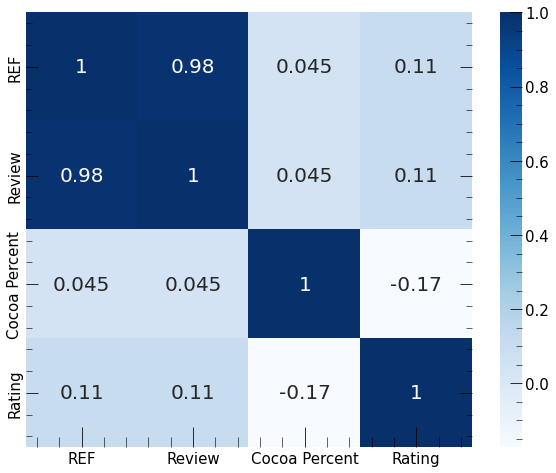

In [40]:
plt.figure(figsize = (10,8))
plt.rcParams.update({
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
})
sns.heatmap(df_train.corr(), annot=True, cmap="Blues")

plt.show()

## Correlation matrix (categorical features)

In [41]:
import association_metrics as am

XC = df_train.apply(lambda x: x.astype("category") if x.dtype == "object" else x)
cramersv = am.CramersV(XC)
cramersv.fit()

,Company,Specific Bean Origin,Company Location,Bean Type,Broad Bean Origin
Company,1.000000,0.771074,0.999651,0.616841,0.603687
Specific Bean Origin,0.771074,1.000000,0.808500,0.907956,0.983438
Company Location,0.999651,0.808500,1.000000,0.291616,0.383209
Bean Type,0.616841,0.907956,0.291616,1.000000,0.388240
Broad Bean Origin,0.603687,0.983438,0.383209,0.388240,1.000000


Correlated features (may drop one from each pair):
* REF and Review
* Company and Company Location
* Broad Bean Origin and Specific Bean Origin
* Specific Bean Origin and Bean Type

From every pair of highly correlated categorical features we should drop the one with maximum unique values to avoid overfitting

## Outliers

In [42]:
cat_cols = df_train.columns[df_train.dtypes == 'object']
num_cols = df_train.columns[df_train.dtypes != 'object']

REF


/home/andy/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


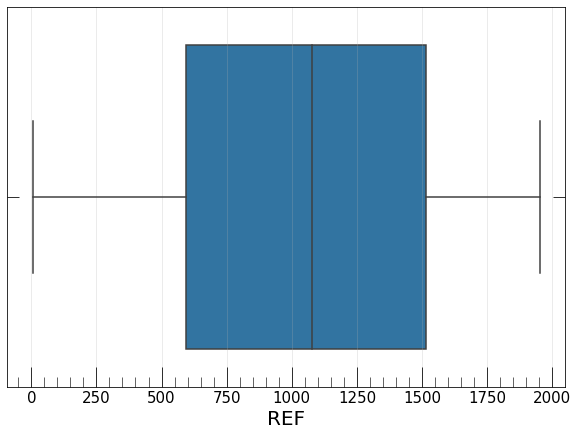

Review


/home/andy/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


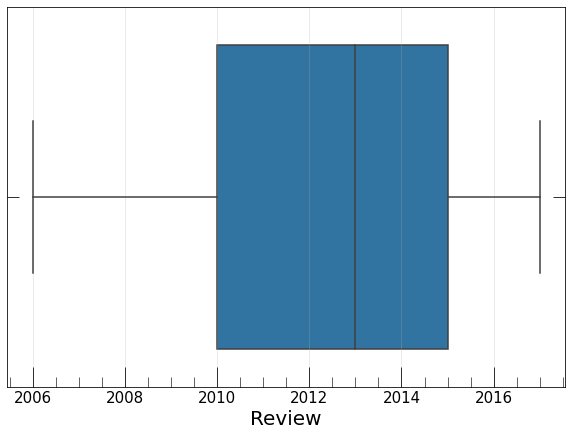

Cocoa Percent


/home/andy/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


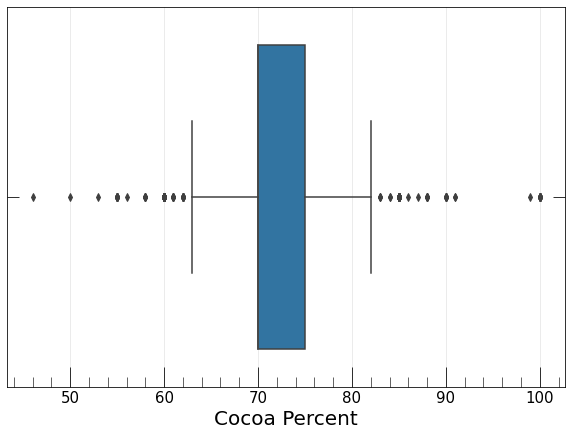

Rating


/home/andy/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


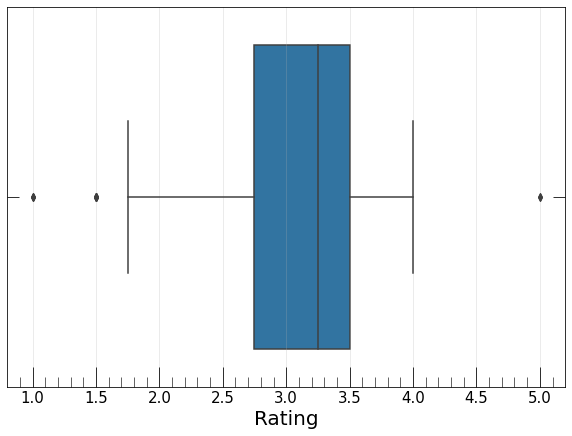

In [43]:
for col in num_cols:
    print(col)
    sns.boxplot(df_train[col])
    plt.show()

In [44]:
outliers_cocoa_percent = df_train[(df_train['Cocoa Percent'] >= 99) | (df_train['Cocoa Percent'] <= 50)]
df_train = df_train.drop(outliers_cocoa_percent.index, axis=0)

outliers_cocoa_percent_test = df_train[(df_train['Cocoa Percent'] >= 99) | (df_train['Cocoa Percent'] <= 50)]
df_test = df_test.drop(outliers_cocoa_percent_test.index, axis=0)

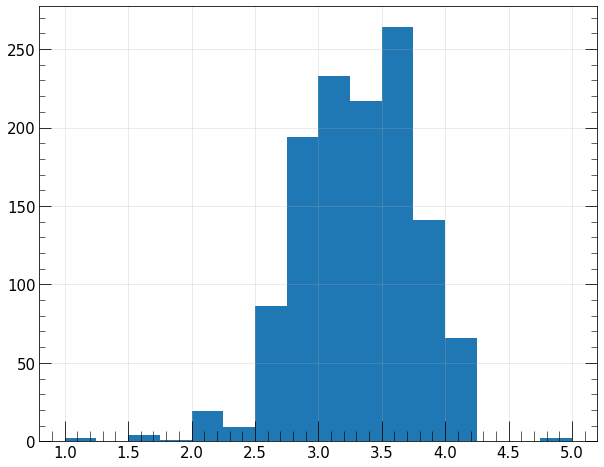

In [45]:
plt.figure(figsize=(10, 8))
plt.hist(df_train['Rating'], bins=16)
plt.show()

In [46]:
#outliers_rating = df_train[(df_train['Rating'] == 5.0) | (df_train['Rating'] <= 1.5)]
#df_train = df_train.drop(outliers_rating.index, axis=0)

# Baseline model (ansamble)

In [ ]:
from sklearn.model_selection import train_test_split

X = df_train.drop('Rating', axis=1)
y = df_train.Rating

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [109]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.pipeline import Pipeline

p_baseline = Pipeline([
    ('encoder', TargetEncoder(cols=cat_cols)),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_jobs=-1))
])

p_baseline.fit(X_train, y_train)
pred = p_baseline.predict(X_val)
r2_score(y_val, pred)

In [ ]:
# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    "model__n_estimators": [180, 200],
    "model__max_depth": [3, 4, 5],
    "model__min_samples_split": [10, 15, 20],
    #"model__min_samples_leaf": []
    #"criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
}
search = GridSearchCV(p_baseline, param_grid, cv=3, n_jobs=-1, scoring='r2')
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

In [ ]:
search.best_estimator_.fit(X_train, y_train)
pred = search.best_estimator_.predict(X_val)
r2_score(y_val, pred)

Not a great result

# CatBoost

In [ ]:
categorical_features_indices = np.where(X.dtypes == object)[0]
categorical_features_indices

In [ ]:
from catboost import CatBoostRegressor

model = CatBoostRegressor()

model.fit(X_train, y_train,
         cat_features=categorical_features_indices,
         eval_set=(X_val, y_val),
         logging_level='Silent')

pred = model.predict(X_val)

r2_score(y_val, pred)

In [ ]:
pd.DataFrame({'Feature': model.feature_names_, "Importance": model.feature_importances_})\
    .sort_values(by='Importance', ascending=False)

## CatBoost hyperparameters tuning

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
import optuna

def objective(trial):

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 16),
    }

    estimator = CatBoostRegressor(**param,
                                  cat_features=categorical_features_indices,
                                  verbose=False)

    estimator.fit(X_train, y_train)
    pred = estimator.predict(X_val)

    return mean_squared_error(y_val, pred)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=15, n_jobs=-1)
print(study.best_trial)

In [ ]:
print(study.best_trial.params)

In [ ]:
model = CatBoostRegressor(**study.best_params,
                         cat_features=categorical_features_indices,
                         logging_level='Silent')

model.fit(X_train, y_train)
pred_cb = model.predict(X_val)

r2_score(y_val, pred_cb)

In [ ]:
model.fit(X, y)

That's better already, let's try it on test

In [ ]:
pd.DataFrame({'Feature': model.feature_names_, "Importance": model.feature_importances_})\
    .sort_values(by='Importance', ascending=False)

## Apply tuned CatBoost to test

In [ ]:
pred_test = model.predict(df_test)
pred_test[:10]

In [ ]:
df_submission = df_test.copy()
df_submission['id'] = np.arange(len(df_test))
df_submission['Rating'] = pred_test
df_submission = df_submission[['id','Rating']]
df_submission.to_csv("CatBoost_v1.csv", index=False)

This model gives r2 = 0.16608 on test. <br>
Which is not very bad but still we must achieve r2 >= 0.2

# Feature engineering

Some ideas I already tried:
* Broad company location (Africa, Caribbean, etc)
* Broader cocoa bean origin (Africa, Caribbean, etc)
* Best Companies (from internet sources)
* Top cocoa bean production countries (amount and quality)

More to try:
* Company location matches broad bean origin
* Analyze text of some features: Specific Bean Origin and Company

### Matched Regions

In [47]:
df_train[['Company Location', 'Broad Bean Origin']].head()

,Company Location,Broad Bean Origin
0,U.K.,Venezuela
1,Switzerland,Venezuela
2,U.S.A.,Tanzania
3,U.S.A.,Dominican Republic
4,France,Indonesia


In [48]:
df_train['Matched Regions'] = np.where(df_train['Company Location'] == df_train['Broad Bean Origin'], 1, 0)
df_test['Matched Regions'] = np.where(df_test['Company Location'] == df_test['Broad Bean Origin'], 1, 0)

In [49]:
df_train.groupby('Matched Regions').agg(MeanRating=('Rating', 'mean'),
                                       StdRating=('Rating', 'std'))

,MeanRating,StdRating
Matched Regions,,
0,3.200228,0.461287
1,3.099650,0.467368


### Broad Locations (parts of the world)

In [50]:
broad_locations = {'Europe': ['U.K.', 'Switzerland', 'France', 'Belgium', 'Spain', 'Italy',
                              'Austria', 'Sweden', 'Ireland', 'Poland', 'Hungary', 'Germany',
                              'Denmark', 'Lithuania', 'Scotland', 'Finland', 'Iceland',
                              'Amsterdam', 'Wales', 'Netherlands', 'Portugal', 'Czech Republic'],
                   'North America': ['U.S.A.', 'Canada'],
                   'Africa': ['Madagascar', 'South Africa', 'Ghana', 'Sao Tome', 'Tanzania',
                              'Indonesia', 'Congo', 'Liberia', 'Principe', 'Sao Tome & Principe',
                              'Gabon', 'Ivory Coast', 'Uganda', 'Nigeria', 'West Africa'],
                   'Caribbean': ['Colombia', 'Venezuela', 'Honduras', 'Guatemala',
                                 'Domincan Republic', 'Grenada', 'Puerto Rico', 'Costa Rica',
                                 'St. Lucia', 'Nicaragua', 'Martinique', 'Niacragua', 'Cost Rica, Ven',
                                 'Trinidad', 'Panama', 'Jamaica', 'Haiti', 'Cuba', 'Venezuela, Ghana',
                                 'Ven.,Ecu.,Peru,Nic.', 'Tobago', 'Carribean(DR/Jam/Tri)',
                                 'Venezuela, Java', 'Ven, Bolivia, D.R.', 'Venezuela, Carribean',
                                 'Dominican Republic', 'Carribean'],
                   'Asia & Oceania': ['Japan', 'Vietnam', 'Philippines', 'Fiji', 'Australia',
                                      'South Korea', 'Israel', 'Singapore', 'India', 'Russia',
                                      'New Zealand', 'Papua New Guinea', 'Hawaii', 'Solomon Islands',
                                      'Sri Lanka', 'Malaysia', 'Samoa', 'Philippines', 'Togo',
                                      'Vanuatu'],
                   'South America': ['Ecuador', 'Brazil', 'Peru', 'Eucador', 'Argentina',
                                     'Chile', 'Mexico', 'Bolivia', 'Suriname', 'Peru, Dom. Rep',
                                     'Central and S. America', 'Colombia, Ecuador', 'Dom. Rep., Madagascar',
                                     'South America', 'Belize', 'El Salvador'],
                   'Mixed': ['Trinidad, Ecuador', 'South America, Africa', 'PNG, Vanuatu, Mad',
                             'Mad., Java, PNG', 'Peru, Mad., Dom. Rep.', 'Indonesia, Ghana', 'Madagascar & Ecuador',
                             'Venez,Africa,Brasil,Peru,Mex', 'DR, Ecuador, Peru', 'Dominican Rep., Bali',
                             'Peru, Madagascar', 'Venezuela, Dom. Rep.', 'Peru, Ecuador, Venezuela',
                             'Ven., Trinidad, Mad.', 'Ven., Indonesia, Ecuad.', 'Ghana, Domin. Rep',
                             'Peru, Belize', 'Guat., D.R., Peru, Mad., PNG']
                   }

In [51]:
def location_in_list(location, locations_dict=broad_locations):
    for k, v in broad_locations.items():
        if location in v:
            return k
    return 'Other'

In [52]:
df_train['Broad Company Location'] = df_train['Company Location'].apply(lambda x: location_in_list(x))
df_test['Broad Company Location'] = df_test['Company Location'].apply(lambda x: location_in_list(x))

In [53]:
df_train.groupby('Broad Company Location').agg(MeanRating=('Rating', 'mean'),
                                               StdRating=('Rating', 'std'))

,MeanRating,StdRating
Broad Company Location,,
Africa,3.125000,0.471621
Asia & Oceania,3.259615,0.381049
Caribbean,3.143443,0.424409
Europe,3.227157,0.500431
North America,3.175576,0.442901
South America,3.075949,0.500568


In [54]:
df_train['Bean Origin World'] = df_train['Broad Bean Origin'].apply(lambda x: location_in_list(x))
df_test['Bean Origin World'] = df_test['Broad Bean Origin'].apply(lambda x: location_in_list(x))

In [55]:
df_train.groupby('Bean Origin World').agg(MeanRating=('Rating', 'mean'),
                                          StdRating=('Rating', 'std'))

,MeanRating,StdRating
Bean Origin World,,
Africa,3.213010,0.449611
Asia & Oceania,3.260526,0.360842
Caribbean,3.196730,0.448081
Mixed,3.342105,0.426635
Other,3.044118,0.666532
South America,3.161290,0.474515


### Best Production

In [56]:
df_train['Rating'].mean()

3.1886106623586428

In [57]:
# Countries producing the best chocolate (according to internet)
best_production_countries = ['Belgium', 'Switzerland', 'Italy', 'Germany', 'Austria', 'Poland',
                             'Ecuador', 'Japan', 'New Zealand', 'Sweden', 'Spain', 'Mexico', 'Brazil',
                             'India', 'Peru', 'Australia', 'U.K.',
                             'Indonesia', 'Tahiland', 'Philippines', 'Ivory Coast', 'U.S.A.']

In [58]:
df_train['Best Production'] = df_train['Company Location'].apply(lambda x: int(x in best_production_countries))
df_test['Best Production'] = df_train['Company Location'].apply(lambda x: int(x in best_production_countries))

In [59]:
df_train.groupby('Best Production').agg(MeanRating=('Rating', 'mean'),
                                        StdRating=('Rating', 'std'),
                                        Count=('Best Production', 'count'))

,MeanRating,StdRating,Count
Best Production,,,
0,3.265753,0.448508,365
1,3.156357,0.465288,873


### Best Bean Type

In [60]:
best_beans_list = ['Criollo', 'Trinitario'] 
df_train['Best Bean Type'] = df_train['Bean Type'].apply(lambda x: int(any([i in x for i in best_beans_list])))
df_test['Best Bean Type'] = df_train['Bean Type'].apply(lambda x: int(any([i in x for i in best_beans_list])))

In [61]:
df_train.groupby('Best Bean Type').agg(MeanRating=('Rating', 'mean'),
                                       StdRating=('Rating', 'std'),
                                       Count=('Best Bean Type', 'count'))

,MeanRating,StdRating,Count
Best Bean Type,,,
0,3.153871,0.478782,788
1,3.249444,0.427513,450


In [62]:
df_train.drop('Best Bean Type', axis=1, inplace=True)
df_test.drop('Best Bean Type', axis=1, inplace=True)

### Multiple Bean Origins

In [63]:
def multiple_names(string):
    answer = 0
    for i  in [',', '&']:
        if i in string:
            answer = 1
    return answer

df_train['Multiple Broad Bean Origins'] = df_train['Broad Bean Origin'].apply(lambda x: multiple_names(x))
df_test['Multiple Broad Bean Origins'] = df_test['Broad Bean Origin'].apply(lambda x: multiple_names(x))

In [64]:
df_train.groupby('Multiple Broad Bean Origins').agg(
    MeanRating=('Rating', 'mean'),
    StdRating=('Rating', 'std'),
    Count=('Multiple Broad Bean Origins', 'count'))

,MeanRating,StdRating,Count
Multiple Broad Bean Origins,,,
0,3.182365,0.461776,1205
1,3.416667,0.453574,33


### Some features from Specific Bean Origin

In [65]:
df_train['SBO Complex'] = df_train['Specific Bean Origin'].apply(lambda x: int(x.count(' ') > 0))
df_test['SBO Complex'] = df_test['Specific Bean Origin'].apply(lambda x: (x.count(' ') > 0))

In [66]:
df_train.groupby('SBO Complex').agg({'Rating': 'mean'})

,Rating
SBO Complex,
0,3.125992
1,3.231608


In [67]:
df_train.drop('SBO Complex', axis=1, inplace=True)
df_test.drop('SBO Complex', axis=1, inplace=True)

#### Found even better lol

In [68]:
df_train['SBO Complexity'] = df_train['Specific Bean Origin'].apply(lambda x: x.count(' '))
df_test['SBO Complexity'] = df_test['Specific Bean Origin'].apply(lambda x: x.count(' '))

In [69]:
df_train.groupby('SBO Complexity').agg({'Rating': 'mean', 'SBO Complexity': 'count'})

,Rating,SBO Complexity
SBO Complexity,,
0,3.125992,504
1,3.200311,322
2,3.214286,175
3,3.198718,117
4,3.313380,71
5,3.387097,31
6,3.576923,13
7,3.600000,5


In [70]:
def length_bin(s: str, min_val=0, max_val=50, step=10) -> int:
    n = len(s)
    bins = np.arange(min_val, max_val+step, step)
    for i in range(bins.shape[0]):
        if n > bins[i] and n <= bins[i+1]:
            return i
    

df_train['SBO Length'] = df_train['Specific Bean Origin'].apply(lambda x: length_bin(x))
df_test['SBO Length'] = df_test['Specific Bean Origin'].apply(lambda x: length_bin(x))

In [71]:
df_train.groupby('SBO Length').agg({'Rating': 'mean', 'SBO Length': 'count'})

,Rating,SBO Length
SBO Length,,
0,3.143456,596
1,3.177793,367
2,3.270000,175
3,3.341176,85
4,3.433333,15


Again there is some trend

In [72]:
import string
def complexity_plus(s):
    n = 0
    symbols = string.punctuation
    for i in symbols:
        n += s.count(i)
    return n

df_train['SBO Complexity plus'] = df_train['Specific Bean Origin'].apply(lambda x: complexity_plus(x))
df_test['SBO Complexity plus'] = df_test['Specific Bean Origin'].apply(lambda x: complexity_plus(x))

In [73]:
df_train.groupby('SBO Complexity plus').agg({'Rating': 'mean', 'SBO Complexity plus': 'count'})

,Rating,SBO Complexity plus
SBO Complexity plus,,
0,3.145313,800
1,3.225410,244
2,3.282178,101
3,3.263158,38
4,3.416667,42
5,3.444444,9
6,3.562500,4


In [74]:
def upper_case(s):
    n = 0
    for i in string.ascii_uppercase:
        n += s.count(i)
    return n

df_train['SBO Upper'] = df_train['Specific Bean Origin'].apply(lambda x: upper_case(x))
df_test['SBO Upper'] = df_test['Specific Bean Origin'].apply(lambda x: upper_case(x))

In [75]:
df_train.groupby('SBO Upper').agg({'Rating': 'mean', 'SBO Upper': 'count'})

,Rating,SBO Upper
SBO Upper,,
0,3.083333,3
1,3.127698,556
2,3.199454,366
3,3.238176,148
4,3.250000,78
5,3.350000,55
6,3.434783,23
7,3.400000,5
8,3.750000,2


### Same for Company

In [76]:
df_train['Company Complexity plus'] = df_train['Company'].apply(lambda x: complexity_plus(x))
df_test['Company Complexity plus'] = df_test['Company'].apply(lambda x: complexity_plus(x))

In [77]:
df_train.groupby('Company Complexity plus').agg({'Rating': 'mean'})

,Rating
Company Complexity plus,
0,3.201777
1,3.240476
2,3.071138
3,2.875000
4,3.305556


In [78]:
df_train['Company Length'] = df_train['Company'].apply(lambda x: length_bin(x, 0, 40, 5))
df_test['Company Length'] = df_test['Company'].apply(lambda x: length_bin(x, 0, 40, 5))

In [79]:
df_train.groupby('Company Length').agg({'Rating': 'mean'})

,Rating
Company Length,
0,3.217105
1,3.217791
2,3.186966
3,3.159091
4,3.040123
5,3.065476
6,3.208333
7,3.416667


In [80]:
df_train['Company Complexity'] = df_train['Company'].apply(lambda x: x.count(' '))
df_test['Company Complexity'] = df_test['Company'].apply(lambda x: x.count(' '))

In [81]:
df_train.groupby('Company Complexity').agg({'Rating': 'mean'})

,Rating
Company Complexity,
0,3.223607
1,3.162757
2,3.138199
3,3.017442
4,3.227273


In [82]:
df_train['Company Upper'] = df_train['Company'].apply(lambda x: upper_case(x))
df_test['Company Upper'] = df_test['Company'].apply(lambda x: upper_case(x))

In [83]:
df_train.groupby('Company Upper').agg({'Rating': 'mean'})

,Rating
Company Upper,
0,3.045455
1,3.236580
2,3.161125
3,3.093972
4,3.102564
5,2.666667
6,2.500000


## Feature selection

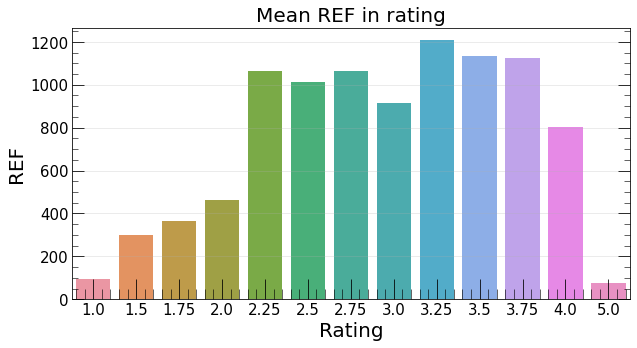

In [84]:
def distribution(data, title, x_label, y_label, figsize=(10,5)):
    plt.figure(figsize=figsize)
    plt.style.use('seaborn-pastel')
    density = sns.barplot(x=data.index, y=data.values)
    title = plt.title(title, fontdict={'fontsize': 20})
    plt.xlabel(x_label)
    plt.ylabel(y_label)
plt.show()

rating_cocoa_percent_dist = df_train.groupby('Rating')['REF'].mean()

distribution(data=rating_cocoa_percent_dist,
             title='Mean REF in rating',
             x_label='Rating',
             y_label='REF')

In [85]:
train_rating = df_train.Rating
df_train.drop('Rating', axis=1, inplace=True)
df_train['Rating'] = train_rating

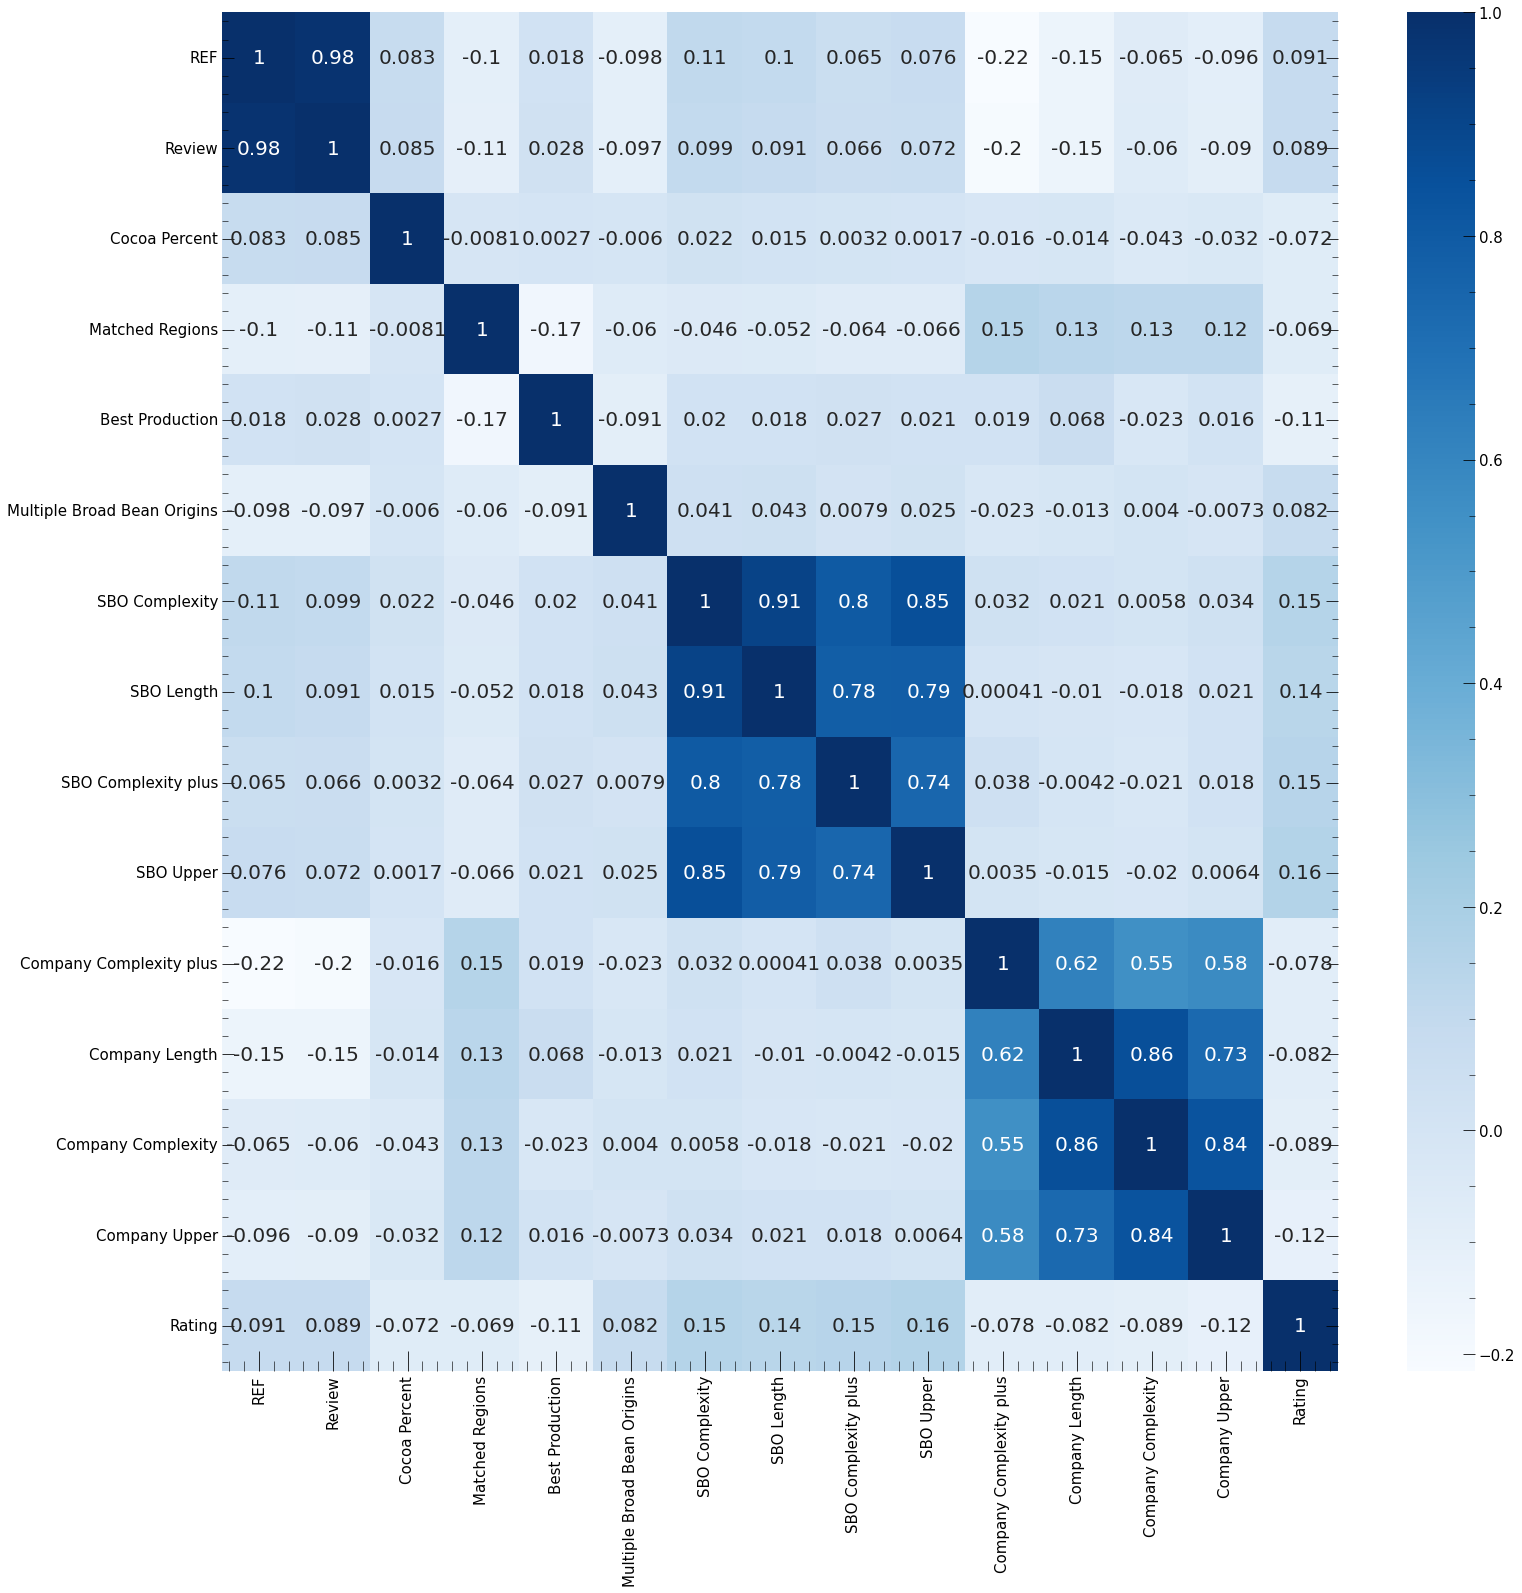

In [86]:
plt.figure(figsize = (25, 25))
plt.rcParams.update({
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
})
sns.heatmap(df_train.corr(), annot=True, cmap="Blues")

plt.show()

In [87]:
numeric_columns = df_train.columns[(df_train.dtypes == int) | (df_train.dtypes == float)]
new_columns = numeric_columns[[any(j in i for j in ['SBO', 'Company', 'Rating']) for i in numeric_columns]]
new_columns

Index(['SBO Complexity', 'SBO Length', 'SBO Complexity plus', 'SBO Upper',
       'Company Complexity plus', 'Company Length', 'Company Complexity',
       'Company Upper', 'Rating'],
      dtype='object')

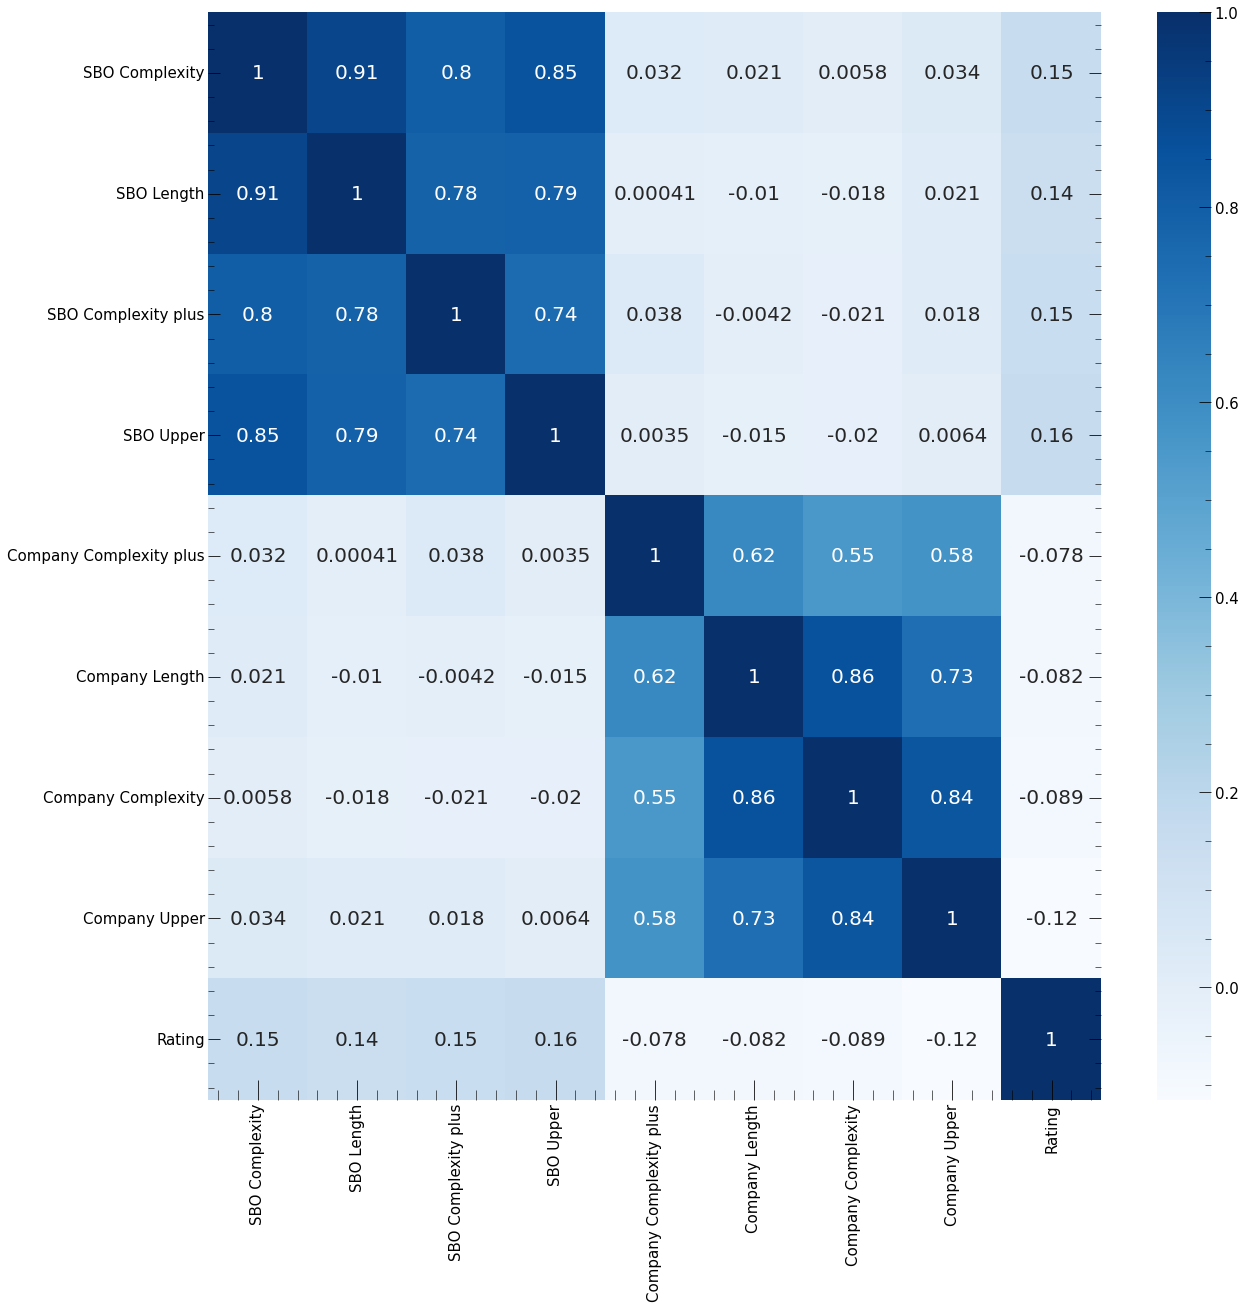

In [88]:
plt.figure(figsize = (20, 20))
plt.rcParams.update({
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
})
sns.heatmap(df_train[new_columns].corr(), annot=True, cmap="Blues")

plt.show()

Keep 'SBO complexity' and 'Company Upper'

In [89]:
cols_to_drop = np.delete(new_columns, [0, 7, 8])
cols_to_drop

Index(['SBO Length', 'SBO Complexity plus', 'SBO Upper',
       'Company Complexity plus', 'Company Length', 'Company Complexity'],
      dtype='object')

In [90]:
df_train = df_train.drop(cols_to_drop, axis=1)
df_test = df_test.drop(cols_to_drop, axis=1)

In [91]:
df_train.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin,Matched Regions,Broad Company Location,Bean Origin World,Best Production,Multiple Broad Bean Origins,SBO Complexity,Company Upper,Rating
0,Willie's Cacao,Rio Caribe,457,2009,72.0,U.K.,Trinitario,Venezuela,0,Europe,Caribbean,1,0,1,2,3.25
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72.0,Switzerland,Unknown,Venezuela,0,Europe,Caribbean,1,0,5,2,3.50
2,Dark Forest,Tanzania,1554,2015,70.0,U.S.A.,Unknown,Tanzania,0,North America,Africa,1,0,0,2,3.00
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72.0,U.S.A.,Trinitario,Dominican Republic,0,North America,Caribbean,1,0,0,3,3.00
4,Pralus,"Java, Indonesie",32,2006,75.0,France,Criollo,Indonesia,0,Europe,Africa,0,0,1,1,3.50


## Correlation matrix (categorical features)

In [92]:
import association_metrics as am

XC = df_train.apply(lambda x: x.astype("category") if x.dtype == "object" else x)
cramersv = am.CramersV(XC)
cramersv.fit()

,Company,Specific Bean Origin,Company Location,Bean Type,Broad Bean Origin,Broad Company Location,Bean Origin World
Company,1.000000,0.771841,0.999651,0.616228,0.601980,0.998263,0.639839
Specific Bean Origin,0.771841,1.000000,0.809275,0.907938,0.987188,0.843617,0.991061
Company Location,0.999651,0.809275,1.000000,0.289758,0.378682,1.000000,0.336445
Bean Type,0.616228,0.907938,0.289758,1.000000,0.387478,0.297567,0.394955
Broad Bean Origin,0.601980,0.987188,0.378682,0.387478,1.000000,0.440663,1.000000
Broad Company Location,0.998263,0.843617,1.000000,0.297567,0.440663,1.000000,0.269155
Bean Origin World,0.639839,0.991061,0.336445,0.394955,1.000000,0.269155,1.000000


In [93]:
df_train_backup = df_train.copy()
df_test_backup = df_test.copy()

In [94]:
#df_train = df_train_backup
#df_test = df_test_backup

In [95]:
#df_train.drop(['Specific Bean Origin'], axis=1, inplace=True)
#df_test.drop(['Specific Bean Origin'], axis=1, inplace=True)

In [96]:
df_train = df_train.drop(['Review'], axis=1)
df_test = df_test.drop(['Review'], axis=1)

In [97]:
cols_to_drop = ['Matched Regions', 'Best Production', 'Multiple Broad Bean Origins',
                'Specific Bean Origin'] # 'Company Upper'
df_train = df_train.drop(cols_to_drop, axis=1)
df_test = df_test.drop(cols_to_drop, axis=1)

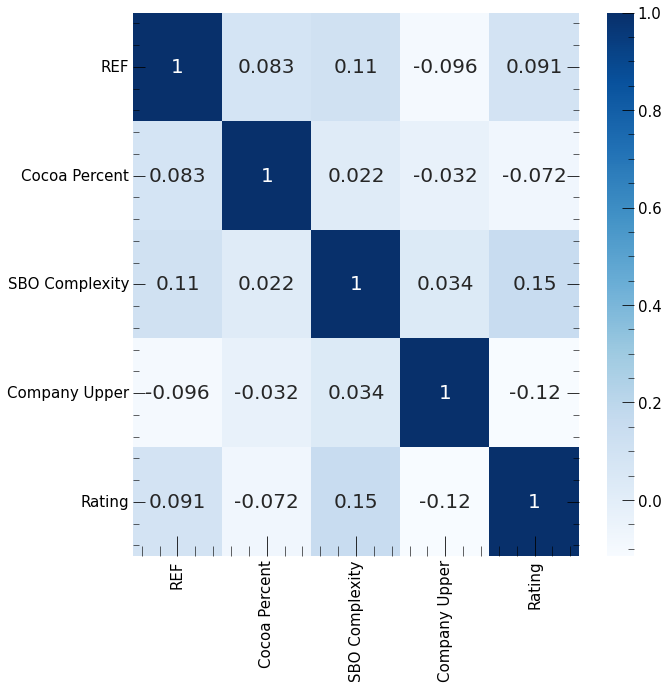

In [102]:
plt.figure(figsize = (10, 10))
plt.rcParams.update({
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
})
sns.heatmap(df_train.corr(), annot=True, cmap="Blues")

plt.show()

# CatBoost with new features

In [105]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import optuna

In [106]:
X = df_train.drop('Rating', axis=1)
y = df_train.Rating

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
categorical_features_indices = np.where(X.dtypes == object)[0]
categorical_features_indices

array([0, 3, 4, 5, 6, 7])

In [110]:
model = CatBoostRegressor()

model.fit(X_train, y_train,
         cat_features=categorical_features_indices,
         eval_set=(X_val, y_val),
         logging_level='Silent')

pred = model.predict(X_val)

r2_score(y_val, pred)

0.21514466077311367

In [111]:
pd.DataFrame({'Feature': model.feature_names_, "Importance": model.feature_importances_})\
    .sort_values(by='Importance', ascending=False)

,Feature,Importance
0,Company,20.508862
4,Bean Type,14.217070
1,REF,14.185303
2,Cocoa Percent,12.604180
3,Company Location,10.501039
5,Broad Bean Origin,7.245950
7,Bean Origin World,6.392976
8,SBO Complexity,5.886070
6,Broad Company Location,5.666321
9,Company Upper,2.792230


## CatBoost hyperparameters tuning

In [112]:
def objective(trial):

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, step=0.001)
        #"min_child_samples": trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    }

    estimator = CatBoostRegressor(**param,
                                  cat_features=categorical_features_indices,
                                  custom_metric='R2',
                                  verbose=False)

    estimator.fit(X_train, y_train)
    pred = estimator.predict(X_val)

    return mean_squared_error(y_val, pred, squared=False)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, n_jobs=-1)
print(study.best_trial)

[I 2023-07-10 23:22:00,576] A new study created in memory with name: no-name-a50340e5-078f-4f87-8c94-2a152fc94a39
[I 2023-07-10 23:22:00,903] Trial 1 finished with value: 0.4305101293763945 and parameters: {'n_estimators': 108, 'max_depth': 1, 'learning_rate': 0.04}. Best is trial 1 with value: 0.4305101293763945.
[I 2023-07-10 23:22:01,200] Trial 4 finished with value: 0.4270882035085485 and parameters: {'n_estimators': 82, 'max_depth': 2, 'learning_rate': 0.037000000000000005}. Best is trial 4 with value: 0.4270882035085485.
[I 2023-07-10 23:22:01,972] Trial 5 finished with value: 0.4253012758327724 and parameters: {'n_estimators': 580, 'max_depth': 1, 'learning_rate': 0.012}. Best is trial 5 with value: 0.4253012758327724.
[I 2023-07-10 23:22:02,264] Trial 0 finished with value: 0.41901648846369655 and parameters: {'n_estimators': 530, 'max_depth': 3, 'learning_rate': 0.029}. Best is trial 0 with value: 0.41901648846369655.
[I 2023-07-10 23:22:03,046] Trial 2 finished with value: 0.

[I 2023-07-10 23:23:29,923] Trial 39 finished with value: 0.41914316705623395 and parameters: {'n_estimators': 137, 'max_depth': 9, 'learning_rate': 0.027000000000000003}. Best is trial 28 with value: 0.4133918402945482.
[I 2023-07-10 23:23:30,076] Trial 40 finished with value: 0.41653990525766543 and parameters: {'n_estimators': 137, 'max_depth': 9, 'learning_rate': 0.028}. Best is trial 28 with value: 0.4133918402945482.
[I 2023-07-10 23:23:30,507] Trial 43 finished with value: 0.4308163341667211 and parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.039}. Best is trial 28 with value: 0.4133918402945482.
[I 2023-07-10 23:23:30,596] Trial 41 finished with value: 0.4176056350708282 and parameters: {'n_estimators': 139, 'max_depth': 9, 'learning_rate': 0.029}. Best is trial 28 with value: 0.4133918402945482.
[I 2023-07-10 23:23:30,827] Trial 44 finished with value: 0.4222256886317535 and parameters: {'n_estimators': 62, 'max_depth': 8, 'learning_rate': 0.038}. Best is t

[I 2023-07-10 23:24:23,703] Trial 79 finished with value: 0.41811989005192135 and parameters: {'n_estimators': 77, 'max_depth': 8, 'learning_rate': 0.047}. Best is trial 57 with value: 0.41205625182881783.
[I 2023-07-10 23:24:24,016] Trial 82 finished with value: 0.44083284950733465 and parameters: {'n_estimators': 15, 'max_depth': 6, 'learning_rate': 0.05}. Best is trial 57 with value: 0.41205625182881783.
[I 2023-07-10 23:24:24,722] Trial 71 finished with value: 0.4185064992150969 and parameters: {'n_estimators': 518, 'max_depth': 8, 'learning_rate': 0.045}. Best is trial 57 with value: 0.41205625182881783.
[I 2023-07-10 23:24:25,004] Trial 81 finished with value: 0.42041910260281173 and parameters: {'n_estimators': 172, 'max_depth': 8, 'learning_rate': 0.05}. Best is trial 57 with value: 0.41205625182881783.
[I 2023-07-10 23:24:25,120] Trial 80 finished with value: 0.41600854591539105 and parameters: {'n_estimators': 177, 'max_depth': 8, 'learning_rate': 0.051000000000000004}. Best 

FrozenTrial(number=57, state=TrialState.COMPLETE, values=[0.41205625182881783], datetime_start=datetime.datetime(2023, 7, 10, 23, 23, 56, 434390), datetime_complete=datetime.datetime(2023, 7, 10, 23, 24, 1, 455542), params={'n_estimators': 341, 'max_depth': 7, 'learning_rate': 0.039}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=10, step=1), 'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.001, step=0.001)}, trial_id=57, value=None)


In [113]:
print(study.best_trial.params)

{'n_estimators': 341, 'max_depth': 7, 'learning_rate': 0.039}


In [114]:
model = CatBoostRegressor(**study.best_params,
                         cat_features=categorical_features_indices,
                         logging_level='Silent')

model.fit(X_train, y_train)
pred_cb = model.predict(X_val)

r2_score(y_val, pred_cb)

0.22044036551157242

That's better already, let's try it on test

In [115]:
pd.DataFrame({'Feature': model.feature_names_, "Importance": model.feature_importances_})\
    .sort_values(by='Importance', ascending=False)

,Feature,Importance
0,Company,19.335623
4,Bean Type,13.641574
1,REF,12.943000
2,Cocoa Percent,10.692137
5,Broad Bean Origin,9.331357
3,Company Location,9.160302
7,Bean Origin World,8.568615
6,Broad Company Location,8.162303
8,SBO Complexity,5.207595
9,Company Upper,2.957495


## Apply tuned CatBoost to test

In [116]:
model.fit(X, y)

In [117]:
pred_test = model.predict(df_test)
pred_test[:10]

array([3.23084322, 3.06807124, 3.09108024, 3.36736934, 2.99901805,
       2.76437012, 3.11616034, 3.0908459 , 3.15708065, 2.90328144])

In [118]:
df_submission = df_test.copy()
df_submission['id'] = np.arange(len(df_test))
df_submission['Rating'] = pred_test
df_submission = df_submission[['id','Rating']]
df_submission.to_csv("CatBoost_v13.csv", index=False)

In [119]:
print(df_train.columns)

Index(['Company', 'REF', 'Cocoa Percent', 'Company Location', 'Bean Type',
       'Broad Bean Origin', 'Broad Company Location', 'Bean Origin World',
       'SBO Complexity', 'Company Upper', 'Rating'],
      dtype='object')


In [120]:
print(study.best_trial.params)

{'n_estimators': 341, 'max_depth': 7, 'learning_rate': 0.039}


With above features and hyperparameters I managed to get r2 = 0.19519